### Feature Extraction & Feature Selection

#### Step 1: Feature Extraction

##### Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from transformers import AutoTokenizer, AutoModel

##### Set seed for reproducibility for CodeBERT Embedding

In [2]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    """Set the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed(seed)  # For current GPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs (if using multiple)
    
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


##### Term-Frequency Inverse-Document Frequency (TF-IDF) & CountVectorizer


Both **Term-Frequency Inverse-Document Frequency (TF-IDF)** and **CountVectorizer** are one of the implementation of **Bag-of-Words (BoW) Approaches**. Due to the keyword-driven nature of code review comments, models like TF-IDF and CountVectorizer are suitable for capturing specific terms. We configured both with the parameter `ngramrange=(1, 3)`, enabling the capture of unigrams, bigrams, and trigrams to identify nuanced operational intents. The parameter `max_features=15000` was set to include frequent tokens while filtering out rare, noise-inducing terms. Given the small-sized dataset (about 900 entries), the BoW approach provided a direct method to quantify term significance related to intended operations without relying on complex contextual embeddings (Sahel 2023b).


We decided to use Softmax Regression as our comparison model with parameter `max_iter=300000` as the terminating condition if the model does not converge as expected. We also include regularization parameter `C=1.0` which moderately controls the margin allowing misclassification in the training data to avoid overfitting. 

Citation: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [3]:

# Classifier without CodeReviewFeatureTransformer
class CodeReviewClassifier:
    def __init__(self, vectorizer_type='tfidf', max_iter=300000, C=1.0):
        """
        Initialize classifier with configurable parameters.

        Args:
            vectorizer_type (str): 'tfidf' or 'count' for vectorization method
            max_iter (int): maximum iterations for LogisticRegression
            C (float): inverse of regularization strength
        """
        # Select vectorizer based on type
        if vectorizer_type.lower() == 'tfidf':
            vectorizer = TfidfVectorizer(
                max_features=15000,
                ngram_range=(1, 3)
            )
        elif vectorizer_type.lower() == 'count':
            vectorizer = CountVectorizer(
                max_features=15000,
                ngram_range=(1, 3)
            )
        else:
            raise ValueError("vectorizer_type must be either 'tfidf' or 'count'")

        self.pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=max_iter,
                C=C,
                class_weight='balanced',
                random_state=42
            ))
        ])
        self.vectorizer_type = vectorizer_type

    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        return self.pipeline.predict(X)

    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)

# Main function to train and evaluate the classifier
def main(vectorizer_type='tfidf', max_iter=300000, C=1.0, 
         train_file='../Model and Dataset/clean_train.xlsx',
         test_file='../Model and Dataset/clean_test.xlsx'):
    """
    Main function to train and evaluate the classifier.

    Args:
        vectorizer_type (str): 'tfidf' or 'count'
        max_iter (int): maximum iterations for LogisticRegression
        C (float): inverse of regularization strength
        train_file (str): path to training data file
        test_file (str): path to test data file
    """
    # Load cleaned data
    train_df = pd.read_excel(train_file)
    test_df = pd.read_excel(test_file)

    print("Dataset sizes:")
    print(f"Train: {len(train_df)}")
    print(f"Test: {len(test_df)}")

    print("\nClass distribution in training data:")
    print(train_df['Expected Operation by Developer'].value_counts(normalize=True))

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_df['Expected Operation by Developer'])

    # Train classifier
    classifier = CodeReviewClassifier(
        vectorizer_type=vectorizer_type,
        max_iter=max_iter,
        C=C
    )
    X_train = train_df['Review Comment']
    classifier.fit(X_train, y_train)

    # Make predictions
    X_test = test_df['Review Comment']
    y_pred = classifier.predict(X_test)
    y_probs = classifier.predict_proba(X_test)

    # Decode labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Evaluate
    if 'Expected Operation by Developer' in test_df.columns:
        y_test = test_df['Expected Operation by Developer']
        y_test_encoded = label_encoder.transform(y_test)
        print(f"\nClassification Report Using {vectorizer_type.upper()} Vectorizer with Softmax Regression:")
        print(classification_report(y_test_encoded, y_pred))

    # Save predictions
    test_df['Predicted Operation'] = y_pred_labels
    class_labels = label_encoder.classes_
    for i, op in enumerate(class_labels):
        test_df[f'{op}_probability'] = y_probs[:, i]

    output_file = f'predictions_{vectorizer_type.lower()}.csv'
    test_df.to_csv(output_file, index=False)
    print(f"\nPredictions saved to '{output_file}'")

if __name__ == "__main__":
    print("Running TF-IDF model...")
    main(vectorizer_type='tfidf', max_iter=300000, C=1.0)
    print("\nRunning Count Vectorizer model...")
    main(vectorizer_type='count', max_iter=300000, C=1.0)


Running TF-IDF model...
Dataset sizes:
Train: 875
Test: 221

Class distribution in training data:
Expected Operation by Developer
insert     0.336000
delete     0.332571
replace    0.331429
Name: proportion, dtype: float64

Classification Report Using TFIDF Vectorizer with Softmax Regression:
              precision    recall  f1-score   support

           0       0.79      0.51      0.62        74
           1       0.74      0.58      0.65        74
           2       0.53      0.84      0.65        73

    accuracy                           0.64       221
   macro avg       0.69      0.64      0.64       221
weighted avg       0.69      0.64      0.64       221


Predictions saved to 'predictions_tfidf.csv'

Running Count Vectorizer model...
Dataset sizes:
Train: 875
Test: 221

Class distribution in training data:
Expected Operation by Developer
insert     0.336000
delete     0.332571
replace    0.331429
Name: proportion, dtype: float64

Classification Report Using COUNT Vectorizer

##### CodeBERT Embeddings 


To evaluate contextually rich representations, we decided to use **CodeBERT** – a BERT variant pre-trained on both natural language (NL) and programming language (PL), which is a kind of Pre-trained Language Model (PTLM). Code review comments often blend NL and PL, thus necessitating a method capable of capturing both semantics and syntax concurrently. CodeBERT’s pre-training on **Masked Language Modeling (MLM)** and **Masked Identifier Modeling (MIM)** made it ideal for our dataset (Wang et al. 2022). We experimented with three different techniques for extracting embeddings:
1. Token-Level Embedding: Embeds each token individually, providing a fine-grained representation for detailed analysis of specific terms.
2. Mean Pooling Embedding: Averages token embeddings to represent the overall context of the comment, useful for understanding broad operational patterns.
3. Max Pooling Embedding: Takes the maximum value across token embeddings to emphasize the most significant features, reducing noise from irrelevant tokens.

In [4]:


class CodeBERTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pooling='cls', model_name='microsoft/codebert-base', max_length=512, batch_size=32):
        self.pooling = pooling
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.seed = seed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Set seed
        set_seed(self.seed)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Set seed before transformation
        set_seed(self.seed)

        if not hasattr(self, 'model'):
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModel.from_pretrained(self.model_name).to(self.device)
        self.model.eval()

        embeddings = []
        for i in range(0, len(X), self.batch_size):
            batch_text = X.iloc[i:i+self.batch_size].tolist() if isinstance(X, pd.Series) else X[i:i+self.batch_size]
            inputs = self.tokenizer(
                batch_text,
                padding=True,
                truncation=True,
                max_length=self.max_length,
                return_tensors='pt'
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                hidden_states = outputs.last_hidden_state
                attention_mask = inputs['attention_mask']

                if self.pooling == 'cls':
                    batch_embeddings = hidden_states[:, 0, :].cpu().numpy()
                elif self.pooling == 'mean':
                    mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
                    sum_embeddings = torch.sum(hidden_states * mask, dim=1)
                    sum_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
                    batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
                elif self.pooling == 'max':
                    mask = attention_mask.unsqueeze(-1).expand(hidden_states.size())
                    hidden_states = hidden_states.masked_fill(mask == 0, float('-inf'))
                    batch_embeddings, _ = torch.max(hidden_states, dim=1)
                    batch_embeddings = batch_embeddings.cpu().numpy()
                else:
                    raise ValueError("Invalid pooling method. Choose from 'cls', 'mean', 'max'.")

            embeddings.append(batch_embeddings)

        return np.vstack(embeddings)

class CodeReviewClassifier:
    def __init__(self, pooling='cls', seed=42):
        self.seed = seed
        set_seed(self.seed)
        self.pipeline = Pipeline([
            ('codebert', CodeBERTTransformer(pooling=pooling)),
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=300000,
                C=1,
                class_weight='balanced',
                random_state=self.seed
            ))
        ])

    def fit(self, X, y):
        set_seed(self.seed)
        return self.pipeline.fit(X, y)

    def predict(self, X):
        set_seed(self.seed)
        return self.pipeline.predict(X)

    def predict_proba(self, X):
        set_seed(self.seed)
        return self.pipeline.predict_proba(X)

def main(pooling_method='cls', seed=42):
    set_seed(seed)
    # Load data
    train_df = pd.read_excel('../Model and Dataset/clean_train.xlsx')
    test_df = pd.read_excel('../Model and Dataset/clean_test.xlsx')

    print(f"\nTraining model with {pooling_method} pooling...")
    print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_df['Expected Operation by Developer'])
    if 'Expected Operation by Developer' in test_df.columns:
        y_test = label_encoder.transform(test_df['Expected Operation by Developer'])
    else:
        y_test = None

    # Train and predict
    classifier = CodeReviewClassifier(pooling=pooling_method)
    classifier.fit(train_df['Review Comment'], y_train)
    y_pred = classifier.predict(test_df['Review Comment'])
    y_probs = classifier.predict_proba(test_df['Review Comment'])

    # Decode predictions
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Evaluate
    if y_test is not None:
        print(f"\nResults with {pooling_method} pooling:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Save predictions
    test_df['Predicted Operation'] = y_pred_labels
    class_labels = label_encoder.classes_
    for i, op in enumerate(class_labels):
        test_df[f'{op}_probability'] = y_probs[:, i]
    test_df.to_csv(f'predictions_codebert_{pooling_method}.csv', index=False)
    print(f"Predictions saved to 'predictions_codebert_{pooling_method}.csv'")

if __name__ == "__main__":
    # Run with different pooling methods
    seed = 42  # You can choose any integer
    for pooling in ['cls', 'mean', 'max']:
        main(pooling_method=pooling, seed=seed)



Training model with cls pooling...
Train size: 875, Test size: 221

Results with cls pooling:
              precision    recall  f1-score   support

      delete       0.63      0.59      0.61        74
      insert       0.51      0.50      0.51        74
     replace       0.49      0.53      0.51        73

    accuracy                           0.54       221
   macro avg       0.55      0.54      0.54       221
weighted avg       0.55      0.54      0.54       221

Predictions saved to 'predictions_codebert_cls.csv'

Training model with mean pooling...
Train size: 875, Test size: 221

Results with mean pooling:
              precision    recall  f1-score   support

      delete       0.65      0.58      0.61        74
      insert       0.56      0.53      0.54        74
     replace       0.54      0.63      0.58        73

    accuracy                           0.58       221
   macro avg       0.58      0.58      0.58       221
weighted avg       0.58      0.58      0.58      

#### Step 2: Feature Selection


We decided to use Chi-Squared Test to perform Feature Selection to reduce the dimensionality of the vectors resulting from the CountVectorizer feature extraction. Due to the `max_features` parameter in `CountVectorizer` only selects the features that frquently occurs in the documents, we will have to rely on the result of Chi-Squared Test to actually select the top features that closely relate to the class label. 


Citation: https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223

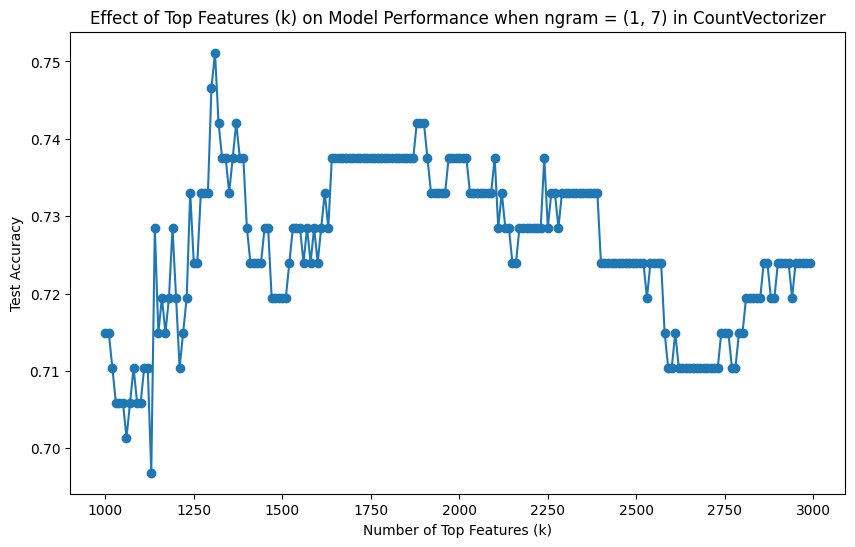

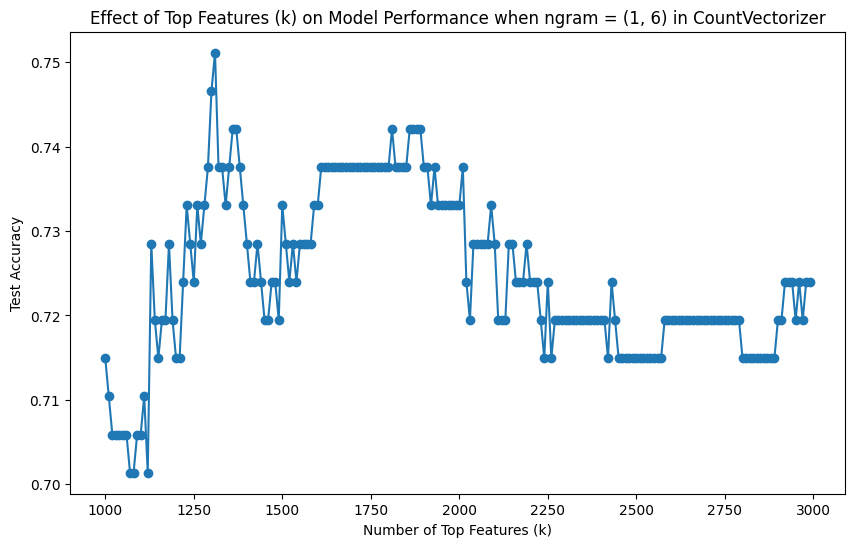

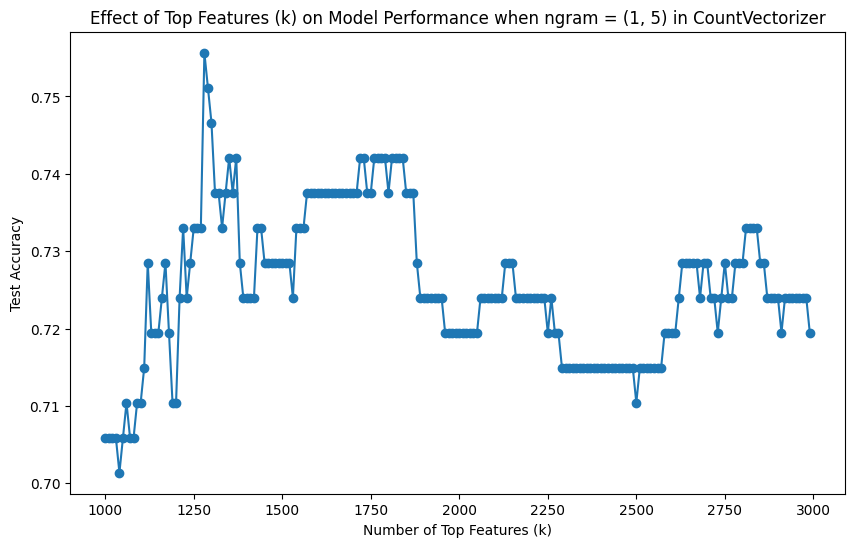

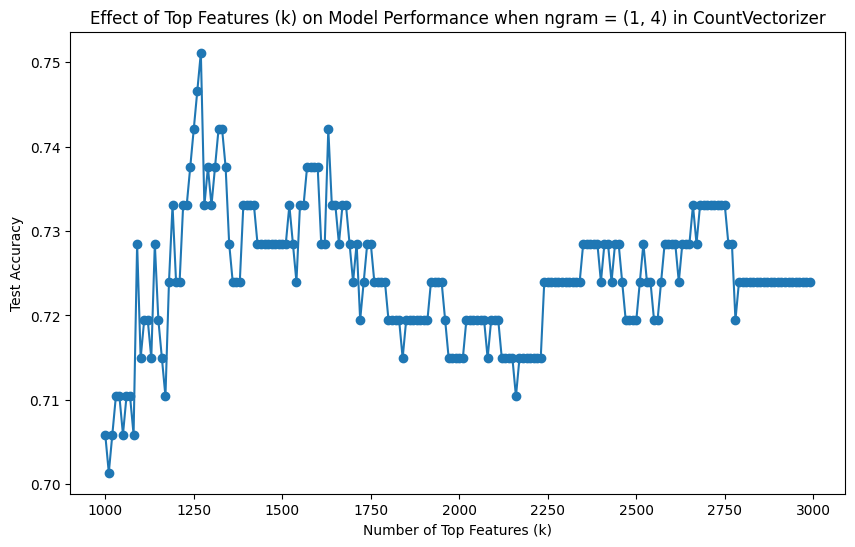

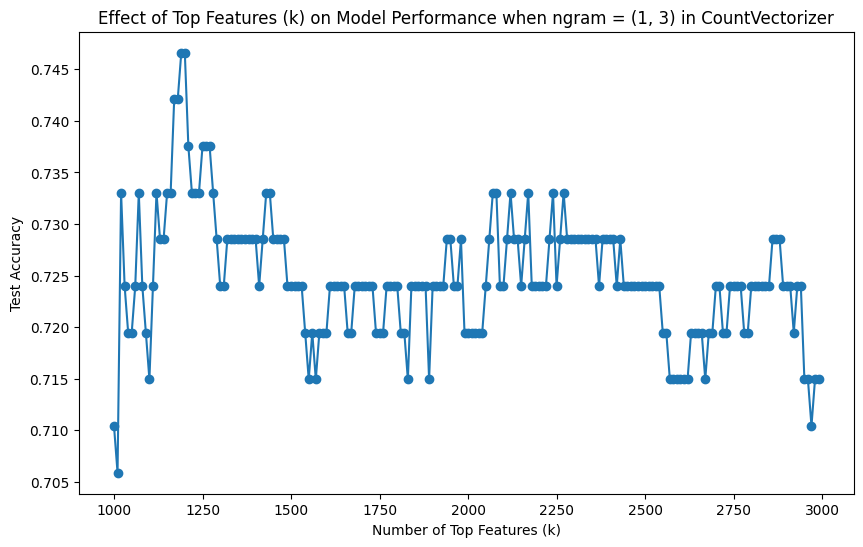

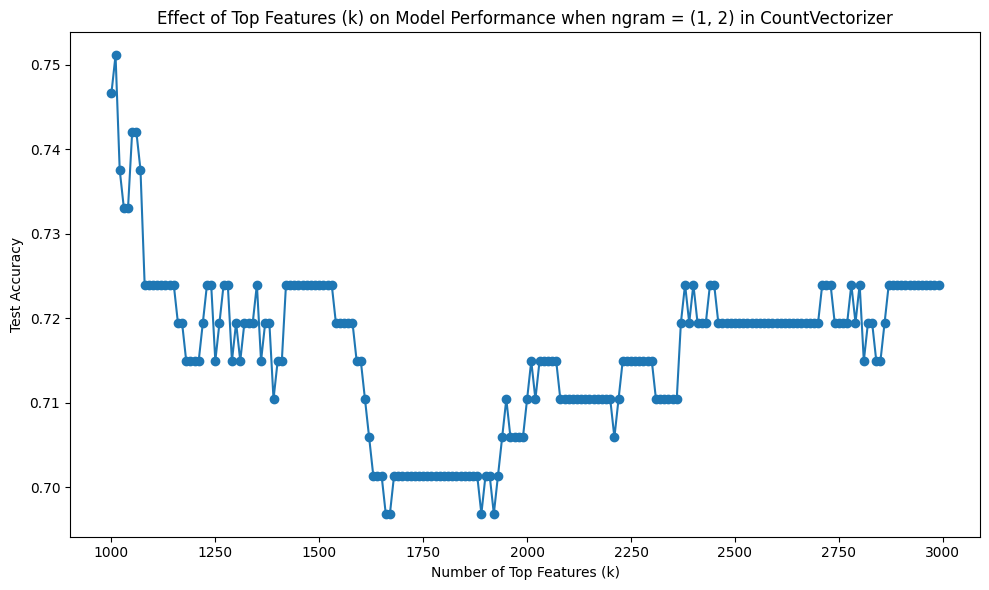

When ngram range for CountVectorizer is 1, 7: 
Optimized Number of Features: 1310
Respective Accuracy: 0.751131221719457

When ngram range for CountVectorizer is 1, 6: 
Optimized Number of Features: 1310
Respective Accuracy: 0.751131221719457

When ngram range for CountVectorizer is 1, 5: 
Optimized Number of Features: 1280
Respective Accuracy: 0.755656108597285

When ngram range for CountVectorizer is 1, 4: 
Optimized Number of Features: 1270
Respective Accuracy: 0.751131221719457

When ngram range for CountVectorizer is 1, 3: 
Optimized Number of Features: 1190
Respective Accuracy: 0.746606334841629

When ngram range for CountVectorizer is 1, 2: 
Optimized Number of Features: 1010
Respective Accuracy: 0.751131221719457



In [5]:
df = pd.read_excel("../Model and Dataset/clean_train.xlsx")
test_df = pd.read_excel("../Model and Dataset/clean_test.xlsx")

# defining labels using numbers
label_mapping = {"delete": 0, "insert": 1, "replace": 2}
df['label'] = df['Expected Operation by Developer'].map(label_mapping)
test_df['label'] = test_df['Expected Operation by Developer'].map(label_mapping)

# extract all data features and labels for training of data
X_train = df["Review Comment"]
y_train = df["label"]
X_test = test_df["Review Comment"]
y_test = test_df["label"]

# record all the best k values and accuracy score according to the ngram range from 1, 7 to 1, 2
bestk_list = []
bestacc_list = []
ngram_list = [7, 6, 5, 4, 3, 2]

for i in ngram_list:
    # test on different ngram range to find if there is any relationship between the ngram range and the optimized number of features
    count_vectorizer = CountVectorizer(ngram_range=(1, i), max_features=60000)
    X_train_counts = count_vectorizer.fit_transform(X_train)
    X_test_counts = count_vectorizer.transform(X_test)

    k_values = range(1000, 3000, 10)  # the peak is noticed around 1000 to 3000 hence this range is chosen
    accuracy_scores = []  # Reset accuracy scores for each ngram range
    bestk, bestacc = 1000, 0

    for k in k_values:
        # Apply SelectKBest with current k value
        selector = SelectKBest(chi2, k=k)
        X_train_kbest = selector.fit_transform(X_train_counts, y_train)
        X_test_kbest = selector.transform(X_test_counts)

        # training and fitting of model using training data
        model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=300000,
                                   C=1, class_weight="balanced", random_state=42)
        model.fit(X_train_kbest, y_train)

        # predicting of data using test data
        y_pred = model.predict(X_test_kbest)

        # calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        accuracy_scores.append(acc)

        if acc > bestacc:
            bestacc = acc
            bestk = k

    bestk_list.append(bestk)
    bestacc_list.append(bestacc)

    # Plot the line and point graph for Accuracy vs. k
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_values), accuracy_scores, marker='o')  # Convert k_values to list for consistency
    plt.xlabel("Number of Top Features (k)")
    plt.ylabel("Test Accuracy")
    plt.title(f"Effect of Top Features (k) on Model Performance when ngram = (1, {i}) in CountVectorizer")

plt.tight_layout()
plt.show()

for i in range(len(bestk_list)):
    print(f"When ngram range for CountVectorizer is 1, {ngram_list[i]}: ")
    print(f"Optimized Number of Features: {bestk_list[i]}")
    print(f"Respective Accuracy: {bestacc_list[i]}")
    print()
